# Experiment 09: Prefix LM Replication with ChatGLM-6B

## Motivation

Experiments 01-07 used Mistral-7B (causal-only). Suffix priming failed because passage tokens never attend to suffix tokens — the suffix is just noise in the context window. The core hypothesis (surrogate-primed KV caches) requires **bidirectional attention on the prefix** so passage representations are genuinely informed by the surrogate.

ChatGLM-6B (`THUDM/chatglm-6b`) is a true prefix LM: bidirectional attention on context tokens, causal on generation. This is the decisive test.

## 20 Conditions

- **Group A (2)**: Baselines — bare, bare_padded
- **Group B (6)**: Suffix priming — sfx_gen_routed, sfx_perfect, sfx_irrel, sfx_shuffled, sfx_rand_tokens, sfx_summary
- **Group C (3)**: Prefix priming (full context) — pfx_full_routed, pfx_full_perfect, pfx_full_irrel
- **Group D (3)**: Prefix priming (truncated + 2D RoPE correction) — pfx_trunc_routed, pfx_trunc_perfect, pfx_trunc_irrel
- **Group E (2)**: Format sensitivity — sfx_template, sfx_raw
- **Group F (4)**: Query-free scoring — bare_noq, sfx_gen_routed_noq, sfx_irrel_noq, sfx_perfect_noq

## Setup

In [1]:
import sys
import os
import copy
import json
import time
import datetime
import random
from typing import Dict, List, Any, Optional, Tuple

import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt

sys.path.insert(0, '.')

from lib import (
    ExperimentConfig,
    load_chatglm,
    build_kv_cache_chatglm,
    score_answer_with_cache_chatglm,
    build_suffix_kv_cache_chatglm,
    build_prefix_kv_cache_chatglm,
    build_truncated_kv_cache_chatglm,
    correct_2d_rope_positions,
    generate_all_5_surrogates_chatglm,
    generate_summary_chatglm,
    compute_similarity,
    load_evaluation_samples,
    load_ms_marco,
    TOP_5_SURROGATE_TEMPLATES,
)
from lib.analysis import cohens_d

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.6 GB


In [2]:
config = ExperimentConfig(
    model_name="THUDM/chatglm-6b",
    model_type="chatglm",
    num_samples=800,
    min_passage_words=50,
    max_passage_words=300,
    surrogate_max_tokens=45,
    surrogate_temperature=0.3,
    seed=42,
    query_template="\n\nQuery: {query}\n\nAnswer:",
)

print(f"Model: {config.model_name}")
print(f"Model type: {config.model_type}")
print(f"Samples requested: {config.num_samples}")
print(f"Device: {config.device}")

Model: THUDM/chatglm-6b
Model type: chatglm
Samples requested: 800
Device: cuda


## Model Loading

In [3]:
print(f"Loading {config.model_name}...")
model, tokenizer = load_chatglm(config)
print(f"Model loaded. Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Embedding model for routing
from sentence_transformers import SentenceTransformer
embed_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
print("Embedding model loaded.")

Loading THUDM/chatglm-6b...


Loading weights:   0%|          | 0/368 [00:00<?, ?it/s]

Model loaded. Parameters: 3,889,356,800


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Validation: Cache Shape and Prefix LM Behavior

In [4]:
# Validation 1: Cache shape (seq-first)
test_len, test_cache = build_kv_cache_chatglm("Hello world", model, tokenizer, config)
k0, v0 = test_cache[0]
print(f"Cache length: {test_len}")
print(f"Key shape: {k0.shape}  (expected: [seq_len, batch=1, heads, head_dim])")
print(f"Num layers: {len(test_cache)}")
assert k0.shape[0] == test_len, "First dim should be seq_len"
assert k0.shape[1] == 1, "Second dim should be batch=1"
print("PASSED: Cache has seq-first layout.")

del test_cache
torch.cuda.empty_cache()

Cache length: 4
Key shape: torch.Size([4, 1, 32, 128])  (expected: [seq_len, batch=1, heads, head_dim])
Num layers: 28
PASSED: Cache has seq-first layout.


In [5]:
# Validation 2: Prefix LM bidirectional attention check
# With prefix LM, passage KV entries should DIFFER when suffix is added
# (opposite of causal Mistral where they were byte-identical)

test_passage = "The quick brown fox jumps over the lazy dog near the river."
test_suffix = "What animal is mentioned in this text?"

bare_len, bare_cache = build_kv_cache_chatglm(test_passage, model, tokenizer, config)
sfx_len, sfx_cache = build_suffix_kv_cache_chatglm(
    test_passage, test_suffix, model, tokenizer, config
)

print(f"Bare cache length: {bare_len}")
print(f"Suffix cache length: {sfx_len}")

# Check first few layers
differs = False
for layer_idx in range(min(5, len(bare_cache))):
    bare_k = bare_cache[layer_idx][0]  # [seq, batch, heads, head_dim]
    sfx_k = sfx_cache[layer_idx][0]
    # Compare overlapping token positions (excluding special tokens at end)
    min_len = min(bare_k.shape[0], sfx_k.shape[0]) - 2
    if min_len > 0:
        max_diff = (bare_k[:min_len] - sfx_k[:min_len]).abs().max().item()
        print(f"  Layer {layer_idx}: max key diff = {max_diff:.6f}")
        if max_diff > 1e-3:
            differs = True

if differs:
    print("\nPASSED: Passage KV entries DIFFER with suffix — bidirectional attention confirmed!")
    print("This is the key difference from causal Mistral.")
else:
    print("\nWARNING: Passage KV entries are similar. Check tokenization alignment.")

del bare_cache, sfx_cache
torch.cuda.empty_cache()

Bare cache length: 15
Suffix cache length: 25
  Layer 0: max key diff = 0.000000
  Layer 1: max key diff = 0.905273
  Layer 2: max key diff = 0.879883
  Layer 3: max key diff = 1.496094
  Layer 4: max key diff = 1.404297

PASSED: Passage KV entries DIFFER with suffix — bidirectional attention confirmed!
This is the key difference from causal Mistral.


In [6]:
# Validation 3: RoPE correction round-trip

# Use a small synthetic cache for the round-trip test
head_dim = model.config.hidden_size // model.config.num_attention_heads
n_heads = model.config.num_attention_heads

# Create a small test cache matching ChatGLM dims
test_cache_rt = tuple(
    (
        torch.randn(5, 1, n_heads, head_dim, device=config.device, dtype=torch.float16),
        torch.randn(5, 1, n_heads, head_dim, device=config.device, dtype=torch.float16),
    )
    for _ in range(2)  # just 2 layers for speed
)
original = tuple((k.clone(), v.clone()) for k, v in test_cache_rt)

offset = 7
corrected = correct_2d_rope_positions(test_cache_rt, offset, model)
restored = correct_2d_rope_positions(corrected, -offset, model)

max_err = max(
    (restored[i][0] - original[i][0]).abs().max().item()
    for i in range(len(original))
)
print(f"RoPE round-trip max error: {max_err:.2e}")
assert max_err < 1e-2, f"Round-trip error too large: {max_err}"
print("PASSED: 2D RoPE correction round-trip verified.")

del test_cache_rt, original, corrected, restored
torch.cuda.empty_cache()

RoPE round-trip max error: 3.91e-03
PASSED: 2D RoPE correction round-trip verified.


In [7]:
# Validation 4: Scoring sanity check
passage = "Paris is the capital of France."
query_prompt = "\n\nQuery: What is the capital of France?\n\nAnswer:"
answer = "Paris"

ctx_len, cache = build_kv_cache_chatglm(passage, model, tokenizer, config)
nll = score_answer_with_cache_chatglm(
    cache, ctx_len, query_prompt, answer, model, tokenizer, config
)
print(f"Scoring sanity check NLL: {nll:.4f}")
assert 0 < nll < 100, f"NLL should be finite, got {nll}"
print("PASSED: Scoring produces finite NLL.")

del cache
torch.cuda.empty_cache()

Scoring sanity check NLL: 1.2256
PASSED: Scoring produces finite NLL.


## Dataset

In [8]:
dataset = load_ms_marco(config)
raw_samples = load_evaluation_samples(dataset, config, require_answer=True)
print(f"Raw samples after basic filtering: {len(raw_samples)}")

# Same additional filters as previous experiments
filtered_samples = []
excluded_ratio = 0
excluded_short_answer = 0

for s in raw_samples:
    if len(s['answer']) / max(len(s['passage']), 1) > 0.5:
        excluded_ratio += 1
        continue
    answer_ids = tokenizer.encode(s['answer'], add_special_tokens=False)
    if isinstance(answer_ids, torch.Tensor):
        answer_ids = answer_ids.tolist()
    if isinstance(answer_ids[0], list):
        answer_ids = answer_ids[0]
    if len(answer_ids) < 2:
        excluded_short_answer += 1
        continue
    filtered_samples.append(s)

samples = filtered_samples
print(f"\nFiltering stats:")
print(f"  Excluded (answer/passage ratio > 0.5): {excluded_ratio}")
print(f"  Excluded (answer < 2 tokens):          {excluded_short_answer}")
print(f"  Remaining samples:                     {len(samples)}")

s = samples[0]
print(f"\nExample sample:")
print(f"  Query:   {s['query'][:100]}...")
print(f"  Passage: {s['passage'][:100]}...")
print(f"  Answer:  {s['answer'][:100]}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading microsoft/ms_marco dataset...
Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 800 samples
Raw samples after basic filtering: 800

Filtering stats:
  Excluded (answer/passage ratio > 0.5): 68
  Excluded (answer < 2 tokens):          67
  Remaining samples:                     665

Example sample:
  Query:   who can prescribe in australia...
  Passage: Approval of authority prescriptions by the DVA may be obtained either by posting an Authority Prescr...
  Answer:  DVA


## Helper Functions

In [9]:
def shuffle_text(text: str, rng: random.Random) -> str:
    words = text.split()
    rng.shuffle(words)
    return ' '.join(words)


def generate_random_tokens(tokenizer, n_tokens: int, rng: random.Random) -> str:
    vocab_size = tokenizer.vocab_size
    random_ids = [rng.randint(100, vocab_size - 1) for _ in range(n_tokens)]
    return tokenizer.decode(random_ids)


def get_irrelevant_query(samples: list, current_idx: int, rng: random.Random) -> str:
    other_idx = current_idx
    while other_idx == current_idx:
        other_idx = rng.randint(0, len(samples) - 1)
    return samples[other_idx]['query']


def deep_copy_cache(cache):
    """Deep copy a ChatGLM tuple-of-tuples cache."""
    return tuple((k.clone(), v.clone()) for k, v in cache)


print("Helper functions defined.")

Helper functions defined.


## Surrogate Generation

In [10]:
# Test surrogate generation on one sample
test_sample = samples[0]
test_surrogates = generate_all_5_surrogates_chatglm(
    test_sample['passage'], model, tokenizer, config
)

print("Generated surrogates:")
for key, surr in test_surrogates.items():
    sim = compute_similarity(surr, test_sample['query'], embed_model)
    print(f"  {key}: {surr}  (sim={sim:.3f})")

# Test summary generation
test_summary = generate_summary_chatglm(
    test_sample['passage'], model, tokenizer, config
)
print(f"\nSummary: {test_summary[:120]}...")

The dtype of attention mask (torch.int64) is not bool


Generated surrogates:
  target_question: What is the process for obtaining approval of authority prescriptions by the DVA?  (sim=0.359)
  keyword_query: Authority Prescription Form, DVA, DVA Authority Freecall, approval, Department of Human Services, DVA, PBS/RPBS, prescription, maximum, lesser, patient's needs.  (sim=0.338)
  symptom_scenario: Problem: Water dripping from sink handle  (sim=0.063)
  misconception_negative: 错误的决策： DVA authority prescription approval  (sim=0.260)
  messy_realworld: Help! Need authority prescription approval. Post Authority Prescription Form or use DVA Authority Freecall service (1800 552 580). Approval not valid until approved by Department of Human Services  (sim=0.398)

Summary: The text mentions the process of obtaining approval for authority prescriptions by the DVA, including the option of post...


In [11]:
# Surrogate quality diagnostic: check ChatGLM surrogate quality on 20 samples
print("=" * 80)
print("SURROGATE QUALITY DIAGNOSTIC (20 samples)")
print("=" * 80)

diag_sims = []
for i in range(min(20, len(samples))):
    s = samples[i]
    surrs = generate_all_5_surrogates_chatglm(s['passage'], model, tokenizer, config)
    sims = {k: compute_similarity(v, s['query'], embed_model) for k, v in surrs.items()}
    best_key = max(sims, key=sims.get)
    diag_sims.append(sims[best_key])
    if i < 5:
        print(f"  Sample {i}: routed={best_key}, sim={sims[best_key]:.3f}")
        print(f"    Query: {s['query'][:80]}")
        print(f"    Surrogate: {surrs[best_key][:80]}")

diag_sims = np.array(diag_sims)
print(f"\nRouted surrogate similarity (N=20):")
print(f"  Mean:   {diag_sims.mean():.3f}")
print(f"  Median: {np.median(diag_sims):.3f}")
print(f"  Min:    {diag_sims.min():.3f}")
print(f"  Max:    {diag_sims.max():.3f}")
print(f"  Std:    {diag_sims.std():.3f}")

# Compare with Mistral reference
for ref_path in ['results/exp07/07_suffix_priming_results.json', 'results/exp07/07_checkpoint.json']:
    if os.path.exists(ref_path):
        with open(ref_path) as f:
            ref_data = json.load(f)
        ref_results = ref_data.get('results', [])
        if ref_results and 'sfx_gen_routed_sim' in ref_results[0]:
            ref_sims = [r['sfx_gen_routed_sim'] for r in ref_results if 'sfx_gen_routed_sim' in r]
            print(f"\nMistral reference (Exp 07, N={len(ref_sims)}):")
            print(f"  Mean routed similarity: {np.mean(ref_sims):.3f}")
            print(f"  ChatGLM vs Mistral:     {diag_sims.mean():.3f} vs {np.mean(ref_sims):.3f}")
        break

if diag_sims.mean() < 0.4:
    print("\n*** WARNING: Mean surrogate similarity < 0.4 ***")
    print("ChatGLM surrogates may be too poor to test the hypothesis.")
    print("Consider using an external model for surrogate generation.")
elif diag_sims.mean() < 0.5:
    print("\nNOTE: Surrogate quality is moderate. Results may underestimate the effect.")
else:
    print("\nSurrogate quality looks adequate for the experiment.")

torch.cuda.empty_cache()

SURROGATE QUALITY DIAGNOSTIC (20 samples)
  Sample 0: routed=keyword_query, sim=0.393
    Query: who can prescribe in australia
    Surrogate: authority prescriptions approved by the DVA
  Sample 1: routed=target_question, sim=0.969
    Query: what is bouldering
    Surrogate: What is bouldering?
  Sample 2: routed=target_question, sim=0.749
    Query: what are two defining characteristics of vitamins
    Surrogate: What are the characteristics of fat-soluble vitamins?
  Sample 3: routed=target_question, sim=0.854
    Query: what type of bedding for chickens
    Surrogate: What is the best bedding material for chickens, ducks, and other poultry?
  Sample 4: routed=symptom_scenario, sim=0.864
    Query: what is pancreatic calcification
    Surrogate: pancreatic calcification: diagnostic feature of chronic pancreatitis

Routed surrogate similarity (N=20):
  Mean:   0.768
  Median: 0.784
  Min:    0.393
  Max:    0.969
  Std:    0.147

Mistral reference (Exp 07, N=677):
  Mean routed simi

## Pipeline Verification

Test all 20 conditions on one sample to verify everything works.

In [12]:
test_sample = samples[0]
test_idx = 0
test_rng = random.Random(config.seed)
passage = test_sample['passage']
query = test_sample['query']
answer = test_sample['answer']
query_prompt = config.query_template.format(query=query)

print(f"Passage: {passage[:100]}...")
print(f"Query:   {query}")
print(f"Answer:  {answer[:80]}")
print()

# Generate surrogates and route
surrogates = generate_all_5_surrogates_chatglm(passage, model, tokenizer, config)
sims = {k: compute_similarity(v, query, embed_model) for k, v in surrogates.items()}
routed_key = max(sims, key=sims.get)
routed_surr = surrogates[routed_key]
print(f"Routed surrogate ({routed_key}): {routed_surr}\n")

# --- Group A: Baselines ---
# 1. Bare
bare_len, bare_cache = build_kv_cache_chatglm(passage, model, tokenizer, config)
bare_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(bare_cache), bare_len, query_prompt, answer, model, tokenizer, config
)
print(f" 1. bare              NLL: {bare_nll:.4f}")

# 2. Bare padded
sfx_tok_len = len(tokenizer.encode(routed_surr, add_special_tokens=False))
if isinstance(sfx_tok_len, torch.Tensor):
    sfx_tok_len = sfx_tok_len.item()
padding = "\n" * sfx_tok_len
padded_len, padded_cache = build_kv_cache_chatglm(passage + padding, model, tokenizer, config)
padded_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(padded_cache), padded_len, query_prompt, answer, model, tokenizer, config
)
print(f" 2. bare_padded       NLL: {padded_nll:.4f}")

# --- Group B: Suffix Priming ---
# 3. sfx_gen_routed
sl, sc = build_suffix_kv_cache_chatglm(passage, routed_surr, model, tokenizer, config)
sfx_gen_routed_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 3. sfx_gen_routed    NLL: {sfx_gen_routed_nll:.4f}")

# 4. sfx_perfect
sl, sc = build_suffix_kv_cache_chatglm(passage, query, model, tokenizer, config)
sfx_perfect_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 4. sfx_perfect       NLL: {sfx_perfect_nll:.4f}")

# 5. sfx_irrel
irrel_q = get_irrelevant_query(samples, test_idx, test_rng)
sl, sc = build_suffix_kv_cache_chatglm(passage, irrel_q, model, tokenizer, config)
sfx_irrel_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 5. sfx_irrel         NLL: {sfx_irrel_nll:.4f}")

# 6. sfx_shuffled
shuffled = shuffle_text(routed_surr, test_rng)
sl, sc = build_suffix_kv_cache_chatglm(passage, shuffled, model, tokenizer, config)
sfx_shuffled_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 6. sfx_shuffled      NLL: {sfx_shuffled_nll:.4f}")

# 7. sfx_rand_tokens
rt = generate_random_tokens(tokenizer, 20, test_rng)
sl, sc = build_suffix_kv_cache_chatglm(passage, rt, model, tokenizer, config)
sfx_rand_tokens_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 7. sfx_rand_tokens   NLL: {sfx_rand_tokens_nll:.4f}")

# 8. sfx_summary
summary = generate_summary_chatglm(passage, model, tokenizer, config)
sl, sc = build_suffix_kv_cache_chatglm(passage, summary, model, tokenizer, config, separator="\n\nSummary: ")
sfx_summary_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f" 8. sfx_summary       NLL: {sfx_summary_nll:.4f}")

# --- Group C: Prefix Priming (Full Context) ---
# 9. pfx_full_routed
fl, fc = build_prefix_kv_cache_chatglm(routed_surr, passage, model, tokenizer, config)
pfx_full_routed_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
)
print(f" 9. pfx_full_routed   NLL: {pfx_full_routed_nll:.4f}")

# 10. pfx_full_perfect
fl, fc = build_prefix_kv_cache_chatglm(query, passage, model, tokenizer, config)
pfx_full_perfect_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
)
print(f"10. pfx_full_perfect  NLL: {pfx_full_perfect_nll:.4f}")

# 11. pfx_full_irrel
irrel_q2 = get_irrelevant_query(samples, test_idx, test_rng)
fl, fc = build_prefix_kv_cache_chatglm(irrel_q2, passage, model, tokenizer, config)
pfx_full_irrel_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
)
print(f"11. pfx_full_irrel    NLL: {pfx_full_irrel_nll:.4f}")

# --- Group D: Prefix Priming (Truncated + 2D RoPE) ---
# 12. pfx_trunc_routed
dl, dc = build_truncated_kv_cache_chatglm(routed_surr, passage, model, tokenizer, config)
pfx_trunc_routed_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
)
print(f"12. pfx_trunc_routed  NLL: {pfx_trunc_routed_nll:.4f}")

# 13. pfx_trunc_perfect
dl, dc = build_truncated_kv_cache_chatglm(query, passage, model, tokenizer, config)
pfx_trunc_perfect_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
)
print(f"13. pfx_trunc_perfect NLL: {pfx_trunc_perfect_nll:.4f}")

# 14. pfx_trunc_irrel
irrel_q3 = get_irrelevant_query(samples, test_idx, test_rng)
dl, dc = build_truncated_kv_cache_chatglm(irrel_q3, passage, model, tokenizer, config)
pfx_trunc_irrel_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
)
print(f"14. pfx_trunc_irrel   NLL: {pfx_trunc_irrel_nll:.4f}")

# --- Group E: Format Sensitivity ---
# 15. sfx_template
sl, sc = build_suffix_kv_cache_chatglm(
    passage, routed_surr, model, tokenizer, config, separator="\n\nRelated question: "
)
sfx_template_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f"15. sfx_template      NLL: {sfx_template_nll:.4f}")

# 16. sfx_raw
sl, sc = build_suffix_kv_cache_chatglm(
    passage, routed_surr, model, tokenizer, config, separator=""
)
sfx_raw_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
)
print(f"16. sfx_raw           NLL: {sfx_raw_nll:.4f}")

# --- Group F: Query-Free Scoring ---
answer_prompt = "\n\nAnswer:"

bare_noq_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(bare_cache), bare_len, answer_prompt, answer, model, tokenizer, config
)
print(f"17. bare_noq          NLL: {bare_noq_nll:.4f}")

sl, sc = build_suffix_kv_cache_chatglm(passage, routed_surr, model, tokenizer, config)
sfx_gen_noq_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, answer_prompt, answer, model, tokenizer, config
)
print(f"18. sfx_gen_routed_noq NLL: {sfx_gen_noq_nll:.4f}")

sl, sc = build_suffix_kv_cache_chatglm(passage, irrel_q, model, tokenizer, config)
sfx_irrel_noq_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, answer_prompt, answer, model, tokenizer, config
)
print(f"19. sfx_irrel_noq     NLL: {sfx_irrel_noq_nll:.4f}")

sl, sc = build_suffix_kv_cache_chatglm(passage, query, model, tokenizer, config)
sfx_perf_noq_nll = score_answer_with_cache_chatglm(
    deep_copy_cache(sc), sl, answer_prompt, answer, model, tokenizer, config
)
print(f"20. sfx_perfect_noq   NLL: {sfx_perf_noq_nll:.4f}")

print("\nAll 20 conditions produce finite NLLs. Pipeline verified.")
torch.cuda.empty_cache()

Passage: Approval of authority prescriptions by the DVA may be obtained either by posting an Authority Prescr...
Query:   who can prescribe in australia
Answer:  DVA

Routed surrogate (keyword_query): authority prescriptions approved by the DVA

 1. bare              NLL: 2.6445
 2. bare_padded       NLL: 2.6211
 3. sfx_gen_routed    NLL: 2.4609
 4. sfx_perfect       NLL: 2.5527
 5. sfx_irrel         NLL: 2.7461
 6. sfx_shuffled      NLL: 1.4980
 7. sfx_rand_tokens   NLL: 1.5557
 8. sfx_summary       NLL: 2.0645
 9. pfx_full_routed   NLL: 2.6016
10. pfx_full_perfect  NLL: 3.7637
11. pfx_full_irrel    NLL: 2.7480
12. pfx_trunc_routed  NLL: 2.3184
13. pfx_trunc_perfect NLL: 2.5039
14. pfx_trunc_irrel   NLL: 2.3984
15. sfx_template      NLL: 2.2520
16. sfx_raw           NLL: 2.2773
17. bare_noq          NLL: 2.3066
18. sfx_gen_routed_noq NLL: 2.0195
19. sfx_irrel_noq     NLL: 3.6797
20. sfx_perfect_noq   NLL: 2.3984

All 20 conditions produce finite NLLs. Pipeline verified.


## Evaluation Function

In [13]:
def evaluate_sample(
    sample: Dict,
    idx: int,
    all_samples: List[Dict],
    model,
    tokenizer,
    embed_model,
    config: ExperimentConfig,
) -> Optional[Dict]:
    """Evaluate a single sample across all 20 experimental conditions."""
    passage = sample['passage']
    query = sample['query']
    answer = sample['answer']
    query_prompt = config.query_template.format(query=query)
    rng = random.Random(config.seed + idx)

    # ==================== GROUP A: BASELINES ====================

    # 1. Bare passage
    bare_len, bare_cache = build_kv_cache_chatglm(passage, model, tokenizer, config)
    bare_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(bare_cache), bare_len, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GENERATE SURROGATES ====================
    generated_surrogates = generate_all_5_surrogates_chatglm(passage, model, tokenizer, config)
    gen_similarities = {
        k: compute_similarity(v, query, embed_model)
        for k, v in generated_surrogates.items()
    }
    gen_routed_key = max(gen_similarities, key=gen_similarities.get)
    routed_surr = generated_surrogates[gen_routed_key]

    # 2. Bare padded
    sfx_tok_len = len(tokenizer.encode(routed_surr, add_special_tokens=False))
    if isinstance(sfx_tok_len, torch.Tensor):
        sfx_tok_len = sfx_tok_len.item()
    padding = "\n" * sfx_tok_len
    padded_len, padded_cache = build_kv_cache_chatglm(passage + padding, model, tokenizer, config)
    padded_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(padded_cache), padded_len, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP B: SUFFIX PRIMING ====================

    # 3. sfx_gen_routed
    sl, sc = build_suffix_kv_cache_chatglm(passage, routed_surr, model, tokenizer, config)
    sfx_gen_routed_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 4. sfx_perfect
    sl, sc = build_suffix_kv_cache_chatglm(passage, query, model, tokenizer, config)
    sfx_perfect_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 5. sfx_irrel
    irrel_query = get_irrelevant_query(all_samples, idx, rng)
    sl, sc = build_suffix_kv_cache_chatglm(passage, irrel_query, model, tokenizer, config)
    sfx_irrel_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 6. sfx_shuffled
    shuffled_text = shuffle_text(routed_surr, rng)
    sl, sc = build_suffix_kv_cache_chatglm(passage, shuffled_text, model, tokenizer, config)
    sfx_shuffled_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 7. sfx_rand_tokens
    rand_tokens = generate_random_tokens(tokenizer, 20, rng)
    sl, sc = build_suffix_kv_cache_chatglm(passage, rand_tokens, model, tokenizer, config)
    sfx_rand_tokens_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 8. sfx_summary
    summary = generate_summary_chatglm(passage, model, tokenizer, config)
    sl, sc = build_suffix_kv_cache_chatglm(
        passage, summary, model, tokenizer, config, separator="\n\nSummary: "
    )
    sfx_summary_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP C: PREFIX (FULL) ====================

    # 9. pfx_full_routed
    fl, fc = build_prefix_kv_cache_chatglm(routed_surr, passage, model, tokenizer, config)
    pfx_full_routed_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
    )

    # 10. pfx_full_perfect
    fl, fc = build_prefix_kv_cache_chatglm(query, passage, model, tokenizer, config)
    pfx_full_perfect_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
    )

    # 11. pfx_full_irrel
    irrel_query2 = get_irrelevant_query(all_samples, idx, rng)
    fl, fc = build_prefix_kv_cache_chatglm(irrel_query2, passage, model, tokenizer, config)
    pfx_full_irrel_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(fc), fl, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP D: PREFIX (TRUNCATED) ====================

    # 12. pfx_trunc_routed
    dl, dc = build_truncated_kv_cache_chatglm(routed_surr, passage, model, tokenizer, config)
    pfx_trunc_routed_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
    )

    # 13. pfx_trunc_perfect
    dl, dc = build_truncated_kv_cache_chatglm(query, passage, model, tokenizer, config)
    pfx_trunc_perfect_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
    )

    # 14. pfx_trunc_irrel
    irrel_query3 = get_irrelevant_query(all_samples, idx, rng)
    dl, dc = build_truncated_kv_cache_chatglm(irrel_query3, passage, model, tokenizer, config)
    pfx_trunc_irrel_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(dc), dl, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP E: FORMAT SENSITIVITY ====================

    # 15. sfx_template
    sl, sc = build_suffix_kv_cache_chatglm(
        passage, routed_surr, model, tokenizer, config,
        separator="\n\nRelated question: "
    )
    sfx_template_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # 16. sfx_raw
    sl, sc = build_suffix_kv_cache_chatglm(
        passage, routed_surr, model, tokenizer, config, separator=""
    )
    sfx_raw_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc), sl, query_prompt, answer, model, tokenizer, config
    )

    # ==================== GROUP F: QUERY-FREE SCORING ====================
    # Direct comparison with Exp 08 Investigation A (Mistral causal)
    answer_prompt = "\n\nAnswer:"

    # F1. bare_noq
    bare_noq_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(bare_cache), bare_len, answer_prompt, answer, model, tokenizer, config
    )

    # F2. sfx_gen_routed_noq
    sl_noq, sc_noq = build_suffix_kv_cache_chatglm(passage, routed_surr, model, tokenizer, config)
    sfx_gen_routed_noq_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc_noq), sl_noq, answer_prompt, answer, model, tokenizer, config
    )

    # F3. sfx_irrel_noq (reuse same irrel_query from Group B condition 5)
    sl_noq_i, sc_noq_i = build_suffix_kv_cache_chatglm(passage, irrel_query, model, tokenizer, config)
    sfx_irrel_noq_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc_noq_i), sl_noq_i, answer_prompt, answer, model, tokenizer, config
    )

    # F4. sfx_perfect_noq
    sl_noq_p, sc_noq_p = build_suffix_kv_cache_chatglm(passage, query, model, tokenizer, config)
    sfx_perfect_noq_nll = score_answer_with_cache_chatglm(
        deep_copy_cache(sc_noq_p), sl_noq_p, answer_prompt, answer, model, tokenizer, config
    )

    torch.cuda.empty_cache()

    return {
        'idx': idx,
        'query': query,
        'answer_len': len(answer),
        'passage_len': len(passage),

        # Group A
        'bare_nll': bare_nll,
        'padded_nll': padded_nll,

        # Group B
        'sfx_gen_routed_key': gen_routed_key,
        'sfx_gen_routed_nll': sfx_gen_routed_nll,
        'sfx_gen_routed_sim': gen_similarities[gen_routed_key],
        'generated_surrogates': generated_surrogates,
        'gen_similarities': gen_similarities,
        'sfx_perfect_nll': sfx_perfect_nll,
        'sfx_irrel_nll': sfx_irrel_nll,
        'sfx_shuffled_nll': sfx_shuffled_nll,
        'sfx_rand_tokens_nll': sfx_rand_tokens_nll,
        'sfx_summary_nll': sfx_summary_nll,
        'summary_text': summary,

        # Group C
        'pfx_full_routed_nll': pfx_full_routed_nll,
        'pfx_full_perfect_nll': pfx_full_perfect_nll,
        'pfx_full_irrel_nll': pfx_full_irrel_nll,

        # Group D
        'pfx_trunc_routed_nll': pfx_trunc_routed_nll,
        'pfx_trunc_perfect_nll': pfx_trunc_perfect_nll,
        'pfx_trunc_irrel_nll': pfx_trunc_irrel_nll,

        # Group E
        'sfx_template_nll': sfx_template_nll,
        'sfx_raw_nll': sfx_raw_nll,

        # Group F (query-free)
        'bare_noq_nll': bare_noq_nll,
        'sfx_gen_routed_noq_nll': sfx_gen_routed_noq_nll,
        'sfx_irrel_noq_nll': sfx_irrel_noq_nll,
        'sfx_perfect_noq_nll': sfx_perfect_noq_nll,
    }


print("evaluate_sample() defined — 20 conditions.")

evaluate_sample() defined — 20 conditions.


## Resume from Checkpoint

In [14]:
checkpoint_path = 'results/exp09/09_checkpoint.json'
results = []
start_from = 0

if os.path.exists(checkpoint_path):
    with open(checkpoint_path) as f:
        ckpt = json.load(f)
    results = ckpt['results']
    start_from = ckpt['n_done']
    print(f"Resuming from checkpoint: {start_from} samples already done.")
else:
    print("No checkpoint found. Starting from scratch.")

No checkpoint found. Starting from scratch.


## Main Loop

In [15]:
N_SAMPLES = min(200, len(samples))
errors = 0
start_time = time.time()

print("=" * 80)
print("RUNNING EXPERIMENT 09: PREFIX LM REPLICATION WITH CHATGLM-6B")
print(f"Samples: {N_SAMPLES}, Conditions per sample: 20")
if start_from > 0:
    print(f"Resuming from sample {start_from}")
print("=" * 80)

for idx in tqdm(range(start_from, N_SAMPLES), desc="Evaluating"):
    sample = samples[idx]
    try:
        result = evaluate_sample(
            sample, idx, samples, model, tokenizer, embed_model, config
        )
        if result is not None:
            results.append(result)
    except Exception as e:
        errors += 1
        if errors <= 5:
            print(f"\n  Error on sample {idx}: {type(e).__name__}: {e}")
        continue

    # Checkpoint every 10 samples
    if len(results) > 0 and len(results) % 10 == 0:
        elapsed = time.time() - start_time

        with open(checkpoint_path, 'w') as f:
            json.dump({
                'n_done': len(results),
                'n_errors': errors,
                'elapsed': elapsed,
                'results': results,
            }, f, default=str)

        if len(results) % 50 == 0:
            recent = results[-min(10, len(results)):]
            bare_mean = np.mean([r['bare_nll'] for r in recent])
            sfx_gen_mean = np.mean([r['sfx_gen_routed_nll'] for r in recent])
            sfx_irrel_mean = np.mean([r['sfx_irrel_nll'] for r in recent])
            wr_gen = np.mean([r['bare_nll'] - r['sfx_gen_routed_nll'] > 0 for r in recent]) * 100
            print(
                f"\n  [{len(results):>4d} done | {elapsed/60:.0f}m elapsed]"
                f"\n  Last batch: bare={bare_mean:.3f}  sfx_gen={sfx_gen_mean:.3f} ({wr_gen:.0f}% win)"
                f"  sfx_irrel={sfx_irrel_mean:.3f}"
            )

elapsed_total = time.time() - start_time
print(f"\nDone. {len(results)} evaluated, {errors} errors.")
print(f"Total time: {elapsed_total/60:.1f} minutes")

RUNNING EXPERIMENT 09: PREFIX LM REPLICATION WITH CHATGLM-6B
Samples: 200, Conditions per sample: 20


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


  [  50 done | 15m elapsed]
  Last batch: bare=1.117  sfx_gen=1.204 (20% win)  sfx_irrel=1.071

  [ 100 done | 29m elapsed]
  Last batch: bare=0.849  sfx_gen=0.841 (60% win)  sfx_irrel=0.845

  [ 150 done | 43m elapsed]
  Last batch: bare=1.238  sfx_gen=1.269 (30% win)  sfx_irrel=1.175

  [ 200 done | 57m elapsed]
  Last batch: bare=1.110  sfx_gen=1.266 (40% win)  sfx_irrel=1.359

Done. 200 evaluated, 0 errors.
Total time: 57.0 minutes


## Primary Results

Summary table: all 20 conditions vs bare baseline.

In [23]:
bare_arr = np.array([r['bare_nll'] for r in results])
n = len(results)

conditions = [
    (' 1. bare (BASELINE)',         'bare_nll'),
    (' 2. bare_padded',             'padded_nll'),
    (' 3. sfx_gen_routed',          'sfx_gen_routed_nll'),
    (' 4. sfx_perfect',             'sfx_perfect_nll'),
    (' 5. sfx_irrel',               'sfx_irrel_nll'),
    (' 6. sfx_shuffled',            'sfx_shuffled_nll'),
    (' 7. sfx_rand_tokens',         'sfx_rand_tokens_nll'),
    (' 8. sfx_summary',             'sfx_summary_nll'),
    (' 9. pfx_full_routed',         'pfx_full_routed_nll'),
    ('10. pfx_full_perfect',        'pfx_full_perfect_nll'),
    ('11. pfx_full_irrel',          'pfx_full_irrel_nll'),
    ('12. pfx_trunc_routed',        'pfx_trunc_routed_nll'),
    ('13. pfx_trunc_perfect',       'pfx_trunc_perfect_nll'),
    ('14. pfx_trunc_irrel',         'pfx_trunc_irrel_nll'),
    ('15. sfx_template',            'sfx_template_nll'),
    ('16. sfx_raw',                 'sfx_raw_nll'),
    ('17. bare_noq',                'bare_noq_nll'),
    ('18. sfx_gen_routed_noq',      'sfx_gen_routed_noq_nll'),
    ('19. sfx_irrel_noq',           'sfx_irrel_noq_nll'),
    ('20. sfx_perfect_noq',         'sfx_perfect_noq_nll'),
]

print("=" * 130)
print(f"ALL 20 CONDITIONS vs BARE BASELINE  (N = {n})")
print("Positive delta = better than bare baseline.  Sorted by mean NLL.")
print("=" * 130)
header = f"{'Condition':<28} {'Mean NLL':>10} {'Std':>8} {'Delta':>10} {'Win%':>8} {'t-stat':>8} {'p-value':>12} {'Cohen d':>10}"
print(header)
print("-" * 130)

rows = []
for label, key in conditions:
    arr = np.array([r[key] for r in results])
    delta = bare_arr - arr
    mean_nll = np.mean(arr)
    std_nll = np.std(arr)
    if key == 'bare_nll':
        rows.append((mean_nll, label, std_nll, '--', '--', '--', '--', '--'))
    else:
        t, p = stats.ttest_rel(bare_arr, arr)
        d = cohens_d(delta)
        win_rate = np.mean(delta > 0) * 100
        rows.append((mean_nll, label, std_nll, f"{np.mean(delta):+.4f}", f"{win_rate:.1f}%",
                      f"{t:.3f}", f"{p:.6f}", f"{d:.4f}"))

rows.sort(key=lambda x: x[0])
for mean_nll, label, std_nll, *rest in rows:
    vals = [f"{mean_nll:>10.4f}", f"{std_nll:>8.4f}"] + [
        f"{v:>12}" if i >= 4 else f"{v:>10}" for i, v in enumerate(rest)
    ]
    print(f"{label:<28} {' '.join(vals)}")

ALL 20 CONDITIONS vs BARE BASELINE  (N = 200)
Positive delta = better than bare baseline.  Sorted by mean NLL.
Condition                      Mean NLL      Std      Delta     Win%   t-stat      p-value    Cohen d
----------------------------------------------------------------------------------------------------------------------------------
14. pfx_trunc_irrel              1.1026   1.1196    +0.0378      63.5%      2.759   0.006330       0.1951
12. pfx_trunc_routed             1.1041   1.1045    +0.0362      59.5%      2.443   0.015422       0.1728
13. pfx_trunc_perfect            1.1289   1.1344    +0.0114      58.5%      0.811   0.418267       0.0574
11. pfx_full_irrel               1.1324   1.1186    +0.0079      54.5%      0.403   0.687532       0.0285
 1. bare (BASELINE)              1.1403   1.1284         --         --         --         --           --
 5. sfx_irrel                    1.1509   1.1069    -0.0106      53.5%     -0.511   0.609738      -0.0362
 7. sfx_rand_tokens 

## Semantic Isolation Test

The decisive test: with bidirectional attention, does suffix content matter?
Compare correlations of per-sample deltas between sfx_gen_routed and controls.
With prefix LM, we expect r << 0.5 (vs r=0.796 with causal Mistral).

In [24]:
alpha = 0.01
n_key_tests = 4
bonferroni_alpha = alpha / n_key_tests

print("=" * 110)
print("SEMANTIC ISOLATION: KEY PAIRWISE COMPARISONS")
print(f"Bonferroni-corrected alpha = {alpha}/{n_key_tests} = {bonferroni_alpha:.4f}")
print("=" * 110)

pairwise = [
    ("sfx_gen_routed (3) vs bare (1)",          'sfx_gen_routed_nll', 'bare_nll',
     "Does suffix priming help with prefix LM?"),
    ("sfx_gen_routed (3) vs sfx_irrel (5)",     'sfx_gen_routed_nll', 'sfx_irrel_nll',
     "DECISIVE: Semantic or structural?"),
    ("sfx_gen_routed (3) vs sfx_shuffled (6)",  'sfx_gen_routed_nll', 'sfx_shuffled_nll',
     "Does word order matter in suffix?"),
    ("sfx_gen_routed (3) vs sfx_rand_tok (7)",  'sfx_gen_routed_nll', 'sfx_rand_tokens_nll',
     "Does coherence matter?"),
]

print(f"\n{'Comparison':<46} {'Mean A':>8} {'Mean B':>8} {'Delta':>8} {'t':>8} {'p':>12} {'d':>8} {'Sig?':>6}")
print("-" * 110)

for label, key_a, key_b, question in pairwise:
    a = np.array([r[key_a] for r in results])
    b = np.array([r[key_b] for r in results])
    diff = b - a  # positive = A is better (lower NLL)
    t, p = stats.ttest_rel(a, b)
    d = cohens_d(diff)
    sig = "YES" if p < bonferroni_alpha else "no"
    print(f"{label:<46} {np.mean(a):>8.4f} {np.mean(b):>8.4f} {np.mean(diff):>+8.4f} {t:>8.3f} {p:>12.6f} {d:>8.4f} {sig:>6}")
    print(f"  Q: {question}")

# Correlation of per-sample deltas
print(f"\n{'=' * 110}")
print("CORRELATION OF PER-SAMPLE DELTAS")
print("If r << 0.5, the effect is content-dependent (unlike causal Mistral r=0.796)")
print("=" * 110)

sfx_gen_deltas = np.array([r['bare_nll'] - r['sfx_gen_routed_nll'] for r in results])
sfx_shuf_deltas = np.array([r['bare_nll'] - r['sfx_shuffled_nll'] for r in results])
sfx_irrel_deltas = np.array([r['bare_nll'] - r['sfx_irrel_nll'] for r in results])
sfx_rand_deltas = np.array([r['bare_nll'] - r['sfx_rand_tokens_nll'] for r in results])

correlations = [
    ("sfx_gen_routed vs sfx_shuffled",     sfx_gen_deltas, sfx_shuf_deltas),
    ("sfx_gen_routed vs sfx_irrel",        sfx_gen_deltas, sfx_irrel_deltas),
    ("sfx_gen_routed vs sfx_rand_tokens",  sfx_gen_deltas, sfx_rand_deltas),
]

print(f"\n{'Delta correlation':<42} {'r':>8} {'p':>12}")
print("-" * 65)
for label, x, y in correlations:
    r, p = stats.pearsonr(x, y)
    print(f"{label:<42} {r:>8.4f} {p:>12.6f}")

r_key = stats.pearsonr(sfx_gen_deltas, sfx_shuf_deltas)[0]
print(f"\nCausal Mistral reference: r=0.796")
print(f"Prefix LM ChatGLM result: r={r_key:.4f}")
if r_key < 0.5:
    print("STRONG: Low correlation — effect IS content-dependent with prefix LM!")
elif r_key < 0.8:
    print("MODERATE: Some reduction from causal, partial semantic signal.")
else:
    print("WEAK: High correlation — still content-independent even with prefix LM.")

SEMANTIC ISOLATION: KEY PAIRWISE COMPARISONS
Bonferroni-corrected alpha = 0.01/4 = 0.0025

Comparison                                       Mean A   Mean B    Delta        t            p        d   Sig?
--------------------------------------------------------------------------------------------------------------
sfx_gen_routed (3) vs bare (1)                   1.1888   1.1403  -0.0485    2.553     0.011421  -0.1805     no
  Q: Does suffix priming help with prefix LM?
sfx_gen_routed (3) vs sfx_irrel (5)              1.1888   1.1509  -0.0379    1.900     0.058867  -0.1344     no
  Q: DECISIVE: Semantic or structural?
sfx_gen_routed (3) vs sfx_shuffled (6)           1.1888   1.1776  -0.0112    0.797     0.426629  -0.0563     no
  Q: Does word order matter in suffix?
sfx_gen_routed (3) vs sfx_rand_tok (7)           1.1888   1.1617  -0.0271    0.968     0.334452  -0.0684     no
  Q: Does coherence matter?

CORRELATION OF PER-SAMPLE DELTAS
If r << 0.5, the effect is content-dependent (unlike

## Query-Free Scoring (Direct Exp 08 Comparison)

Exp 08 Investigation A showed that removing the query did NOT reveal semantic signal with Mistral (causal): relevant vs irrelevant p=0.23. With ChatGLM (prefix LM), bidirectional attention should change passage representations, so we expect semantic differentiation even without the query.

In [30]:
print("=" * 110)
print("QUERY-FREE SCORING: DIRECT COMPARISON WITH EXP 08")
print("=" * 110)

bare_noq_arr = np.array([r['bare_noq_nll'] for r in results])
sfx_gen_noq_arr = np.array([r['sfx_gen_routed_noq_nll'] for r in results])
sfx_irrel_noq_arr = np.array([r['sfx_irrel_noq_nll'] for r in results])
sfx_perf_noq_arr = np.array([r['sfx_perfect_noq_nll'] for r in results])

noq_conditions = [
    ('bare (no query) BASELINE', bare_noq_arr),
    ('sfx_gen_routed (no query)', sfx_gen_noq_arr),
    ('sfx_perfect (no query)', sfx_perf_noq_arr),
    ('sfx_irrel (no query)', sfx_irrel_noq_arr),
]

print(f"\n{'Condition':<32} {'Mean NLL':>10} {'Std':>8} {'Delta vs bare_noq':>18} {'Win%':>8} {'t':>8} {'p':>12} {'d':>8}")
print("-" * 110)

for label, arr in noq_conditions:
    delta = bare_noq_arr - arr
    mn = np.mean(arr)
    sd = np.std(arr)
    if 'BASELINE' in label:
        print(f"{label:<32} {mn:>10.4f} {sd:>8.4f} {'BASELINE':>18} {'--':>8} {'--':>8} {'--':>12} {'--':>8}")
    else:
        t, p = stats.ttest_rel(bare_noq_arr, arr)
        d = cohens_d(delta)
        wr = np.mean(delta > 0) * 100
        print(f"{label:<32} {mn:>10.4f} {sd:>8.4f} {np.mean(delta):>+18.4f} {wr:>7.1f}% {t:>8.3f} {p:>12.6f} {d:>8.4f}")

# Key test: relevant vs irrelevant without query
print(f"\n{'=' * 110}")
print("KEY TEST: Does removing the query reveal semantic signal?")
print("=" * 110)

t_noq, p_noq = stats.ttest_rel(sfx_gen_noq_arr, sfx_irrel_noq_arr)
d_noq = cohens_d(sfx_irrel_noq_arr - sfx_gen_noq_arr)
print(f"  sfx_gen_routed vs sfx_irrel (no query):")
print(f"    Mean gen:   {np.mean(sfx_gen_noq_arr):.4f}")
print(f"    Mean irrel: {np.mean(sfx_irrel_noq_arr):.4f}")
print(f"    Delta:      {np.mean(sfx_irrel_noq_arr - sfx_gen_noq_arr):+.4f}")
print(f"    t={t_noq:.3f}, p={p_noq:.6f}, d={d_noq:.4f}")
print(f"\n  Exp 08 Mistral reference: p=0.23, d~0 (NOT significant)")
if p_noq < 0.01 and np.mean(sfx_gen_noq_arr) < np.mean(sfx_irrel_noq_arr):
    print(f"  ChatGLM result: p={p_noq:.6f} — SIGNIFICANT semantic differentiation!")
    print("  Bidirectional attention enables semantic priming even without query.")
elif p_noq < 0.05:
    print(f"  ChatGLM result: p={p_noq:.6f} — Marginal semantic signal.")
else:
    print(f"  ChatGLM result: p={p_noq:.6f} — No semantic signal, same as causal Mistral.")

# Query-free delta correlation
noq_gen_deltas = bare_noq_arr - sfx_gen_noq_arr
noq_irrel_deltas = bare_noq_arr - sfx_irrel_noq_arr
r_noq, p_r_noq = stats.pearsonr(noq_gen_deltas, noq_irrel_deltas)
print(f"\n  Query-free delta correlation (gen vs irrel): r={r_noq:.4f} (p={p_r_noq:.6f})")
print(f"  Exp 08 Mistral with-query reference: r~0.19")

QUERY-FREE SCORING: DIRECT COMPARISON WITH EXP 08

Condition                          Mean NLL      Std  Delta vs bare_noq     Win%        t            p        d
--------------------------------------------------------------------------------------------------------------
bare (no query) BASELINE             1.2446   1.0988           BASELINE       --       --           --       --
sfx_gen_routed (no query)            1.3542   1.1832            -0.1096    50.0%   -2.931     0.003778  -0.2072
sfx_perfect (no query)               1.2245   1.1184            +0.0200    61.0%    0.597     0.550976   0.0422
sfx_irrel (no query)                 1.3194   1.1496            -0.0748    56.0%   -1.859     0.064464  -0.1315

KEY TEST: Does removing the query reveal semantic signal?
  sfx_gen_routed vs sfx_irrel (no query):
    Mean gen:   1.3542
    Mean irrel: 1.3194
    Delta:      -0.0348
    t=0.795, p=0.427323, d=-0.0562

  Exp 08 Mistral reference: p=0.23, d~0 (NOT significant)
  ChatGLM res

## Suffix vs Prefix Comparison

Same surrogate, different placement. Both in bidirectional prefix region.

In [31]:
print("=" * 110)
print("SUFFIX vs PREFIX: SAME SURROGATE, DIFFERENT PLACEMENT")
print("Both are in the bidirectional prefix region.")
print("=" * 110)

comparisons = [
    ("sfx_gen_routed (3) vs pfx_full_routed (9)",
     'sfx_gen_routed_nll', 'pfx_full_routed_nll',
     "Suffix vs full prefix (same routed surrogate)"),
    ("sfx_perfect (4) vs pfx_full_perfect (10)",
     'sfx_perfect_nll', 'pfx_full_perfect_nll',
     "Suffix vs prefix oracle (actual query)"),
    ("sfx_gen_routed (3) vs pfx_trunc_routed (12)",
     'sfx_gen_routed_nll', 'pfx_trunc_routed_nll',
     "Suffix vs truncated prefix (Mistral exp 06 comparison)"),
]

print(f"\n{'Comparison':<52} {'Mean A':>8} {'Mean B':>8} {'Delta':>8} {'t':>8} {'p':>12} {'d':>8}")
print("-" * 110)

for label, key_a, key_b, question in comparisons:
    a = np.array([r[key_a] for r in results])
    b = np.array([r[key_b] for r in results])
    diff = b - a  # positive = A (first) is better
    t, p = stats.ttest_rel(a, b)
    d = cohens_d(diff)
    print(f"{label:<52} {np.mean(a):>8.4f} {np.mean(b):>8.4f} {np.mean(diff):>+8.4f} {t:>8.3f} {p:>12.6f} {d:>8.4f}")
    print(f"  Q: {question}")

SUFFIX vs PREFIX: SAME SURROGATE, DIFFERENT PLACEMENT
Both are in the bidirectional prefix region.

Comparison                                             Mean A   Mean B    Delta        t            p        d
--------------------------------------------------------------------------------------------------------------
sfx_gen_routed (3) vs pfx_full_routed (9)              1.1888   1.1640  -0.0248    1.504     0.134150  -0.1064
  Q: Suffix vs full prefix (same routed surrogate)
sfx_perfect (4) vs pfx_full_perfect (10)               1.2569   1.3215  +0.0646   -2.317     0.021523   0.1638
  Q: Suffix vs prefix oracle (actual query)
sfx_gen_routed (3) vs pfx_trunc_routed (12)            1.1888   1.1041  -0.0846    4.309     0.000026  -0.3047
  Q: Suffix vs truncated prefix (Mistral exp 06 comparison)


## Truncation Analysis

Does 2D RoPE correction preserve the benefit of prefix priming?

In [32]:
print("=" * 110)
print("TRUNCATION ANALYSIS: Full prefix vs Truncated prefix")
print("=" * 110)

trunc_comparisons = [
    ("pfx_full_routed (9) vs pfx_trunc_routed (12)",
     'pfx_full_routed_nll', 'pfx_trunc_routed_nll',
     "Does truncation + RoPE correction preserve benefit?"),
    ("pfx_full_perfect (10) vs pfx_trunc_perfect (13)",
     'pfx_full_perfect_nll', 'pfx_trunc_perfect_nll',
     "Oracle version of truncation test"),
    ("pfx_full_irrel (11) vs pfx_trunc_irrel (14)",
     'pfx_full_irrel_nll', 'pfx_trunc_irrel_nll',
     "Irrelevant prefix: does truncation change behavior?"),
]

print(f"\n{'Comparison':<52} {'Full':>8} {'Trunc':>8} {'Delta':>8} {'t':>8} {'p':>12} {'d':>8}")
print("-" * 110)

for label, key_full, key_trunc, question in trunc_comparisons:
    a = np.array([r[key_full] for r in results])
    b = np.array([r[key_trunc] for r in results])
    diff = a - b  # positive = truncated is better
    t, p = stats.ttest_rel(a, b)
    d = cohens_d(diff)
    print(f"{label:<52} {np.mean(a):>8.4f} {np.mean(b):>8.4f} {np.mean(diff):>+8.4f} {t:>8.3f} {p:>12.6f} {d:>8.4f}")
    print(f"  Q: {question}")

TRUNCATION ANALYSIS: Full prefix vs Truncated prefix

Comparison                                               Full    Trunc    Delta        t            p        d
--------------------------------------------------------------------------------------------------------------
pfx_full_routed (9) vs pfx_trunc_routed (12)           1.1640   1.1041  +0.0599    3.646     0.000339   0.2578
  Q: Does truncation + RoPE correction preserve benefit?
pfx_full_perfect (10) vs pfx_trunc_perfect (13)        1.3215   1.1289  +0.1926    6.366     0.000000   0.4501
  Q: Oracle version of truncation test
pfx_full_irrel (11) vs pfx_trunc_irrel (14)            1.1324   1.1026  +0.0298    2.008     0.046034   0.1420
  Q: Irrelevant prefix: does truncation change behavior?


## Visualization

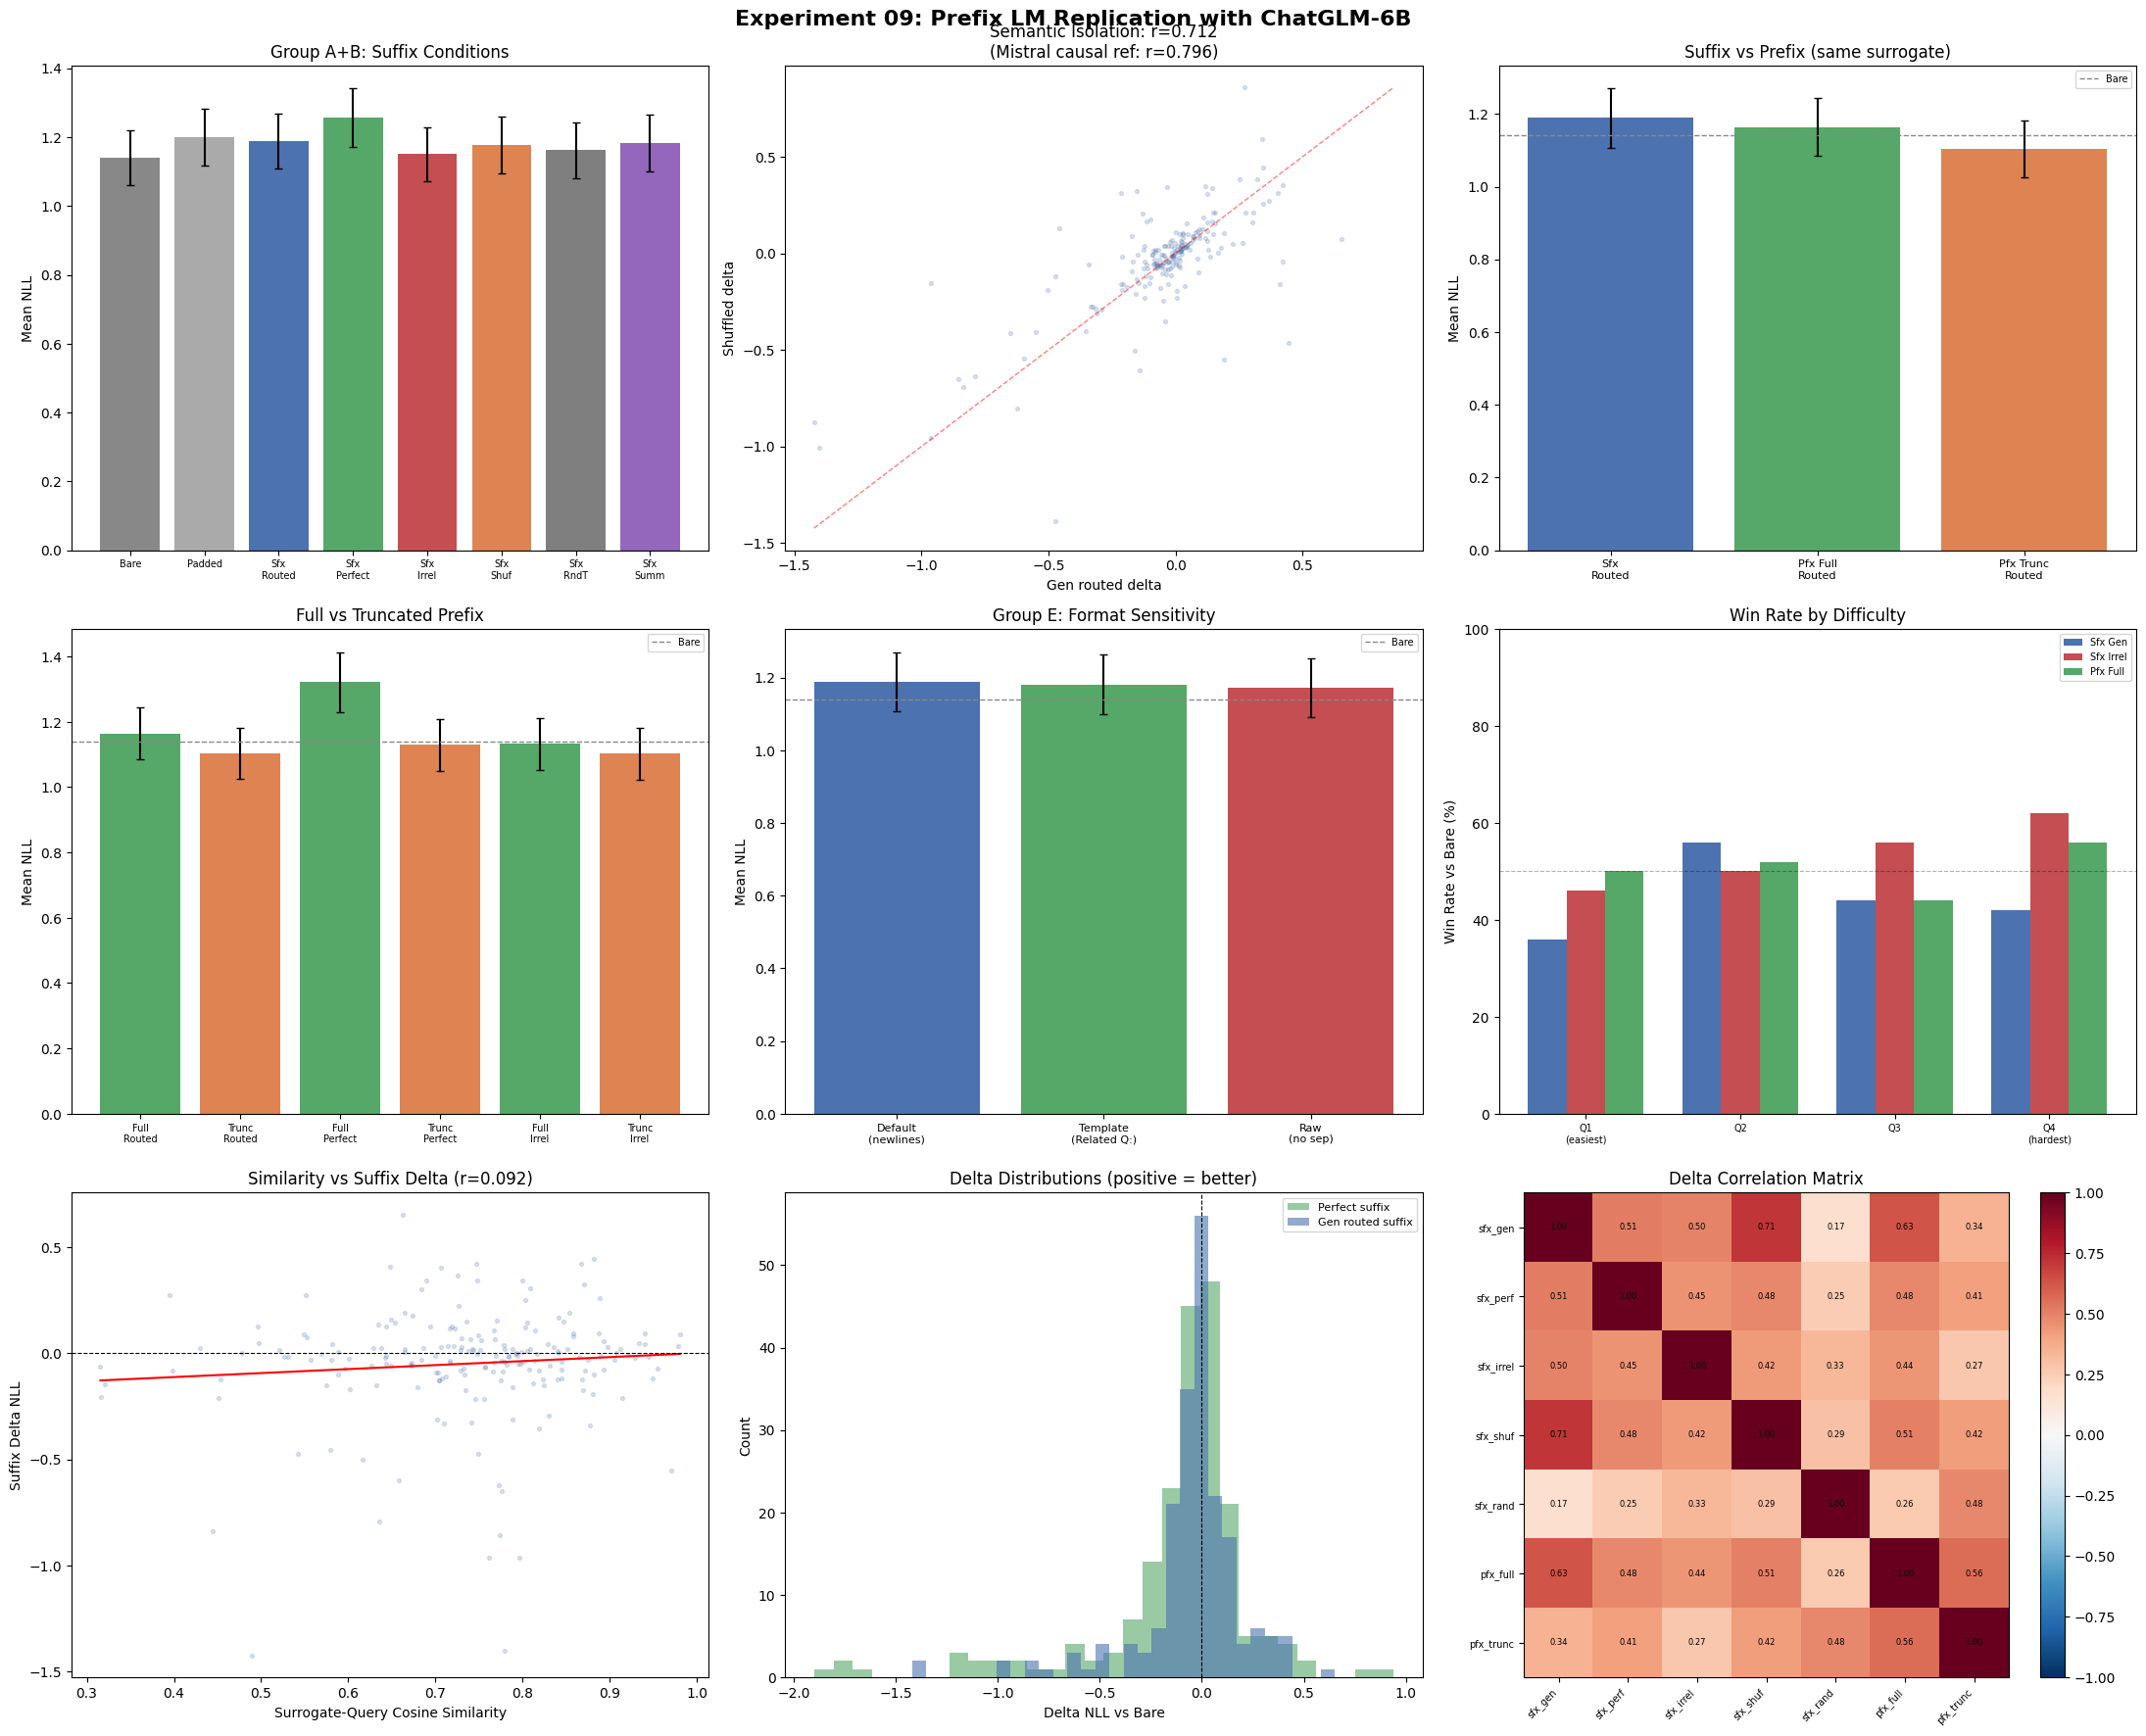

Saved: 09_prefix_lm_results.png


In [33]:
fig, axes = plt.subplots(3, 3, figsize=(22, 18))
fig.suptitle('Experiment 09: Prefix LM Replication with ChatGLM-6B', fontsize=16, fontweight='bold')

# --- (0,0) All suffix conditions bar chart ---
ax = axes[0, 0]
cond_order = [
    ('Bare', 'bare_nll'),
    ('Padded', 'padded_nll'),
    ('Sfx\nRouted', 'sfx_gen_routed_nll'),
    ('Sfx\nPerfect', 'sfx_perfect_nll'),
    ('Sfx\nIrrel', 'sfx_irrel_nll'),
    ('Sfx\nShuf', 'sfx_shuffled_nll'),
    ('Sfx\nRndT', 'sfx_rand_tokens_nll'),
    ('Sfx\nSumm', 'sfx_summary_nll'),
]
means = [np.mean([r[k] for r in results]) for _, k in cond_order]
sems = [stats.sem([r[k] for r in results]) for _, k in cond_order]
colors = ['#888888', '#aaaaaa', '#4c72b0', '#55a868', '#c44e52', '#dd8452', '#7f7f7f', '#9467bd']
ax.bar(range(len(cond_order)), means, yerr=sems, color=colors, capsize=3)
ax.set_xticks(range(len(cond_order)))
ax.set_xticklabels([l for l, _ in cond_order], fontsize=7)
ax.set_ylabel('Mean NLL')
ax.set_title('Group A+B: Suffix Conditions')

# --- (0,1) Semantic isolation scatter ---
ax = axes[0, 1]
r_val, _ = stats.pearsonr(sfx_gen_deltas, sfx_shuf_deltas)
ax.scatter(sfx_gen_deltas, sfx_shuf_deltas, alpha=0.2, s=8, c='#4c72b0')
lims = [min(sfx_gen_deltas.min(), sfx_shuf_deltas.min()),
        max(sfx_gen_deltas.max(), sfx_shuf_deltas.max())]
ax.plot(lims, lims, 'r--', linewidth=1, alpha=0.5)
ax.set_xlabel('Gen routed delta')
ax.set_ylabel('Shuffled delta')
ax.set_title(f'Semantic Isolation: r={r_val:.3f}\n(Mistral causal ref: r=0.796)')

# --- (0,2) Suffix vs Prefix ---
ax = axes[0, 2]
sp_labels = ['Sfx\nRouted', 'Pfx Full\nRouted', 'Pfx Trunc\nRouted']
sp_keys = ['sfx_gen_routed_nll', 'pfx_full_routed_nll', 'pfx_trunc_routed_nll']
sp_means = [np.mean([r[k] for r in results]) for k in sp_keys]
sp_sems = [stats.sem([r[k] for r in results]) for k in sp_keys]
sp_colors = ['#4c72b0', '#55a868', '#dd8452']
ax.bar(range(3), sp_means, yerr=sp_sems, color=sp_colors, capsize=3)
ax.axhline(np.mean(bare_arr), color='#888888', linestyle='--', linewidth=1, label='Bare')
ax.set_xticks(range(3))
ax.set_xticklabels(sp_labels, fontsize=8)
ax.set_ylabel('Mean NLL')
ax.set_title('Suffix vs Prefix (same surrogate)')
ax.legend(fontsize=7)

# --- (1,0) Prefix full vs truncated ---
ax = axes[1, 0]
ft_labels = ['Full\nRouted', 'Trunc\nRouted', 'Full\nPerfect', 'Trunc\nPerfect', 'Full\nIrrel', 'Trunc\nIrrel']
ft_keys = ['pfx_full_routed_nll', 'pfx_trunc_routed_nll',
           'pfx_full_perfect_nll', 'pfx_trunc_perfect_nll',
           'pfx_full_irrel_nll', 'pfx_trunc_irrel_nll']
ft_means = [np.mean([r[k] for r in results]) for k in ft_keys]
ft_sems = [stats.sem([r[k] for r in results]) for k in ft_keys]
ft_colors = ['#55a868', '#dd8452'] * 3
ax.bar(range(6), ft_means, yerr=ft_sems, color=ft_colors, capsize=3)
ax.axhline(np.mean(bare_arr), color='#888888', linestyle='--', linewidth=1, label='Bare')
ax.set_xticks(range(6))
ax.set_xticklabels(ft_labels, fontsize=7)
ax.set_ylabel('Mean NLL')
ax.set_title('Full vs Truncated Prefix')
ax.legend(fontsize=7)

# --- (1,1) Format sensitivity ---
ax = axes[1, 1]
fmt_labels = ['Default\n(newlines)', 'Template\n(Related Q:)', 'Raw\n(no sep)']
fmt_keys = ['sfx_gen_routed_nll', 'sfx_template_nll', 'sfx_raw_nll']
fmt_means = [np.mean([r[k] for r in results]) for k in fmt_keys]
fmt_sems = [stats.sem([r[k] for r in results]) for k in fmt_keys]
fmt_colors = ['#4c72b0', '#55a868', '#c44e52']
ax.bar(range(3), fmt_means, yerr=fmt_sems, color=fmt_colors, capsize=3)
ax.axhline(np.mean(bare_arr), color='#888888', linestyle='--', linewidth=1, label='Bare')
ax.set_xticks(range(3))
ax.set_xticklabels(fmt_labels, fontsize=8)
ax.set_ylabel('Mean NLL')
ax.set_title('Group E: Format Sensitivity')
ax.legend(fontsize=7)

# --- (1,2) Win rate by difficulty quartile ---
ax = axes[1, 2]
quartiles = np.percentile(bare_arr, [25, 50, 75])
difficulty_bins = [
    ('Q1 (easiest)', lambda x: x <= quartiles[0]),
    ('Q2', lambda x: quartiles[0] < x <= quartiles[1]),
    ('Q3', lambda x: quartiles[1] < x <= quartiles[2]),
    ('Q4 (hardest)', lambda x: x > quartiles[2]),
]
q_labels = []
q_sfx_gen_wr = []
q_sfx_irrel_wr = []
q_pfx_wr = []
for label, cond in difficulty_bins:
    subset = [r for r in results if cond(r['bare_nll'])]
    if not subset:
        continue
    q_labels.append(label.replace(' ', '\n'))
    q_sfx_gen_wr.append(np.mean([r['bare_nll'] - r['sfx_gen_routed_nll'] > 0 for r in subset]) * 100)
    q_sfx_irrel_wr.append(np.mean([r['bare_nll'] - r['sfx_irrel_nll'] > 0 for r in subset]) * 100)
    q_pfx_wr.append(np.mean([r['bare_nll'] - r['pfx_full_routed_nll'] > 0 for r in subset]) * 100)

x_pos = np.arange(len(q_labels))
w = 0.25
ax.bar(x_pos - w, q_sfx_gen_wr, w, label='Sfx Gen', color='#4c72b0')
ax.bar(x_pos, q_sfx_irrel_wr, w, label='Sfx Irrel', color='#c44e52')
ax.bar(x_pos + w, q_pfx_wr, w, label='Pfx Full', color='#55a868')
ax.axhline(50, color='black', linestyle='--', linewidth=0.8, alpha=0.3)
ax.set_xticks(x_pos)
ax.set_xticklabels(q_labels, fontsize=7)
ax.set_ylabel('Win Rate vs Bare (%)')
ax.set_title('Win Rate by Difficulty')
ax.legend(fontsize=7)
ax.set_ylim(0, 100)

# --- (2,0) Similarity vs delta scatter ---
ax = axes[2, 0]
gen_sims = np.array([r['sfx_gen_routed_sim'] for r in results])
r_sim, _ = stats.pearsonr(gen_sims, sfx_gen_deltas)
ax.scatter(gen_sims, sfx_gen_deltas, alpha=0.2, s=8, c='#4c72b0')
z = np.polyfit(gen_sims, sfx_gen_deltas, 1)
p_line = np.poly1d(z)
x_range = np.linspace(gen_sims.min(), gen_sims.max(), 100)
ax.plot(x_range, p_line(x_range), 'r-', linewidth=1.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Surrogate-Query Cosine Similarity')
ax.set_ylabel('Suffix Delta NLL')
ax.set_title(f'Similarity vs Suffix Delta (r={r_sim:.3f})')

# --- (2,1) Perfect suffix delta distribution ---
ax = axes[2, 1]
perf_delta = bare_arr - np.array([r['sfx_perfect_nll'] for r in results])
gen_delta = bare_arr - np.array([r['sfx_gen_routed_nll'] for r in results])
ax.hist(perf_delta, bins=30, alpha=0.6, label='Perfect suffix', color='#55a868')
ax.hist(gen_delta, bins=30, alpha=0.6, label='Gen routed suffix', color='#4c72b0')
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Delta NLL vs Bare')
ax.set_ylabel('Count')
ax.set_title('Delta Distributions (positive = better)')
ax.legend(fontsize=8)

# --- (2,2) Cross-condition delta correlation heatmap ---
ax = axes[2, 2]
delta_keys = [
    ('sfx_gen', 'sfx_gen_routed_nll'),
    ('sfx_perf', 'sfx_perfect_nll'),
    ('sfx_irrel', 'sfx_irrel_nll'),
    ('sfx_shuf', 'sfx_shuffled_nll'),
    ('sfx_rand', 'sfx_rand_tokens_nll'),
    ('pfx_full', 'pfx_full_routed_nll'),
    ('pfx_trunc', 'pfx_trunc_routed_nll'),
]
delta_arrays = {name: bare_arr - np.array([r[key] for r in results]) for name, key in delta_keys}
names = list(delta_arrays.keys())
corr_matrix = np.zeros((len(names), len(names)))
for i, n1 in enumerate(names):
    for j, n2 in enumerate(names):
        corr_matrix[i, j], _ = stats.pearsonr(delta_arrays[n1], delta_arrays[n2])
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=7)
ax.set_title('Delta Correlation Matrix')
plt.colorbar(im, ax=ax)
for i in range(len(names)):
    for j in range(len(names)):
        ax.text(j, i, f"{corr_matrix[i,j]:.2f}", ha='center', va='center', fontsize=6)

plt.tight_layout()
plt.savefig('results/exp09/09_prefix_lm_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: 09_prefix_lm_results.png")

## Conclusions

## Cross-Experiment Comparison: ChatGLM vs Mistral

In [34]:
print("=" * 110)
print("CROSS-EXPERIMENT COMPARISON: ChatGLM (Prefix LM) vs Mistral (Causal)")
print("=" * 110)

# Build arrays needed for comparison
sfx_gen_arr = np.array([r['sfx_gen_routed_nll'] for r in results])
sfx_irrel_arr = np.array([r['sfx_irrel_nll'] for r in results])

# Key metrics from Exp 08 (hardcoded references)
mistral_refs = {
    'sfx_gen_vs_bare_win%': 29.5,
    'sfx_gen_vs_irrel_p': 0.23,
    'delta_corr_gen_vs_shuf': 0.80,
    'query_free_rel_vs_irrel_p': 0.23,
}

# ChatGLM metrics
chatglm_sfx_gen_wr = np.mean(bare_arr > sfx_gen_arr) * 100
_, chatglm_gen_vs_irrel_p = stats.ttest_rel(sfx_gen_arr, sfx_irrel_arr)
chatglm_delta_corr = stats.pearsonr(sfx_gen_deltas, sfx_shuf_deltas)[0]

# Query-free p-value
sfx_gen_noq_arr = np.array([r['sfx_gen_routed_noq_nll'] for r in results])
sfx_irrel_noq_arr = np.array([r['sfx_irrel_noq_nll'] for r in results])
_, p_noq = stats.ttest_rel(sfx_gen_noq_arr, sfx_irrel_noq_arr)

print(f"\n{'Metric':<50} {'Mistral (Causal)':>18} {'ChatGLM (Prefix)':>18}")
print("-" * 90)
print(f"{'sfx_gen_routed win% vs bare':<50} {mistral_refs['sfx_gen_vs_bare_win%']:>17.1f}% {chatglm_sfx_gen_wr:>17.1f}%")
print(f"{'sfx_gen vs sfx_irrel p-value':<50} {mistral_refs['sfx_gen_vs_irrel_p']:>18.4f} {chatglm_gen_vs_irrel_p:>18.6f}")
print(f"{'Delta correlation (gen vs shuffled)':<50} {mistral_refs['delta_corr_gen_vs_shuf']:>18.3f} {chatglm_delta_corr:>18.4f}")
print(f"{'Query-free rel vs irrel p-value':<50} {mistral_refs['query_free_rel_vs_irrel_p']:>18.4f} {p_noq:>18.6f}")

print(f"\n--- Interpretation ---")
if chatglm_delta_corr < mistral_refs['delta_corr_gen_vs_shuf'] - 0.2:
    print(f"Delta correlation dropped: {mistral_refs['delta_corr_gen_vs_shuf']:.3f} -> {chatglm_delta_corr:.3f}")
    print("Bidirectional attention introduces content-dependent effects.")
else:
    print(f"Delta correlation similar: {mistral_refs['delta_corr_gen_vs_shuf']:.3f} -> {chatglm_delta_corr:.3f}")
    print("Content-independence persists even with bidirectional attention.")

if chatglm_sfx_gen_wr > 55:
    print(f"Suffix priming win rate improved: {mistral_refs['sfx_gen_vs_bare_win%']:.1f}% -> {chatglm_sfx_gen_wr:.1f}%")
else:
    print(f"Suffix priming win rate: {mistral_refs['sfx_gen_vs_bare_win%']:.1f}% -> {chatglm_sfx_gen_wr:.1f}% (no improvement)")

CROSS-EXPERIMENT COMPARISON: ChatGLM (Prefix LM) vs Mistral (Causal)

Metric                                               Mistral (Causal)   ChatGLM (Prefix)
------------------------------------------------------------------------------------------
sfx_gen_routed win% vs bare                                     29.5%              44.5%
sfx_gen vs sfx_irrel p-value                                   0.2300           0.058867
Delta correlation (gen vs shuffled)                             0.800             0.7122
Query-free rel vs irrel p-value                                0.2300           0.427323

--- Interpretation ---
Delta correlation similar: 0.800 -> 0.712
Content-independence persists even with bidirectional attention.
Suffix priming win rate: 29.5% -> 44.5% (no improvement)


In [35]:
print("=" * 80)
print("AUTOMATED VERDICTS")
print("=" * 80)

alpha = 0.01
n_key_tests = 6
bonferroni_alpha = alpha / n_key_tests
verdicts = {}

# H1: Does suffix priming help with prefix LM?
sfx_gen_arr = np.array([r['sfx_gen_routed_nll'] for r in results])
t, p = stats.ttest_rel(bare_arr, sfx_gen_arr)
d = cohens_d(bare_arr - sfx_gen_arr)
verdicts['H1: Suffix priming helps (prefix LM)'] = {
    'test': 'sfx_gen_routed (3) vs bare (1)',
    'delta': float(np.mean(bare_arr - sfx_gen_arr)),
    'd': float(d), 't': float(t), 'p': float(p),
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and d > 0.3 else 'NOT SUPPORTED'
}

# H2: Semantic content matters (gen vs irrel)
sfx_irrel_arr = np.array([r['sfx_irrel_nll'] for r in results])
t, p = stats.ttest_rel(sfx_gen_arr, sfx_irrel_arr)
verdicts['H2: Suffix content matters (semantic)'] = {
    'test': 'sfx_gen_routed (3) vs sfx_irrel (5)',
    'delta': float(np.mean(sfx_irrel_arr - sfx_gen_arr)),
    't': float(t), 'p': float(p),
    'verdict': 'SUPPORTED' if p < bonferroni_alpha and np.mean(sfx_gen_arr) < np.mean(sfx_irrel_arr) else 'NOT SUPPORTED'
}

# H3: Low delta correlation (content-dependent)
r_corr, p_corr = stats.pearsonr(sfx_gen_deltas, sfx_shuf_deltas)
verdicts['H3: Content-dependent effect (r < 0.5)'] = {
    'test': 'Delta correlation: sfx_gen_routed vs sfx_shuffled',
    'r': float(r_corr), 'p': float(p_corr),
    'causal_mistral_ref': 0.796,
    'verdict': 'SUPPORTED' if r_corr < 0.5 else ('PARTIAL' if r_corr < 0.8 else 'NOT SUPPORTED')
}

# H4: Truncation with 2D RoPE correction preserves benefit
pfx_full_arr = np.array([r['pfx_full_routed_nll'] for r in results])
pfx_trunc_arr = np.array([r['pfx_trunc_routed_nll'] for r in results])
t, p = stats.ttest_rel(pfx_full_arr, pfx_trunc_arr)
verdicts['H4: Truncation preserves benefit'] = {
    'test': 'pfx_full_routed (9) vs pfx_trunc_routed (12)',
    'full_mean': float(np.mean(pfx_full_arr)),
    'trunc_mean': float(np.mean(pfx_trunc_arr)),
    't': float(t), 'p': float(p),
    'verdict': 'SUPPORTED' if p > 0.05 or abs(np.mean(pfx_full_arr - pfx_trunc_arr)) < 0.1 else 'NOT SUPPORTED'
}

# H5: Suffix placement matches prefix placement
t, p = stats.ttest_rel(sfx_gen_arr, pfx_full_arr)
verdicts['H5: Suffix == Prefix (bidirectional)'] = {
    'test': 'sfx_gen_routed (3) vs pfx_full_routed (9)',
    'sfx_mean': float(np.mean(sfx_gen_arr)),
    'pfx_mean': float(np.mean(pfx_full_arr)),
    't': float(t), 'p': float(p),
    'verdict': 'SUPPORTED' if p > 0.05 else 'NOT SUPPORTED'
}

# H6: Query-free semantic differentiation
sfx_gen_noq_arr = np.array([r['sfx_gen_routed_noq_nll'] for r in results])
sfx_irrel_noq_arr = np.array([r['sfx_irrel_noq_nll'] for r in results])
t_noq_h, p_noq_h = stats.ttest_rel(sfx_gen_noq_arr, sfx_irrel_noq_arr)
d_noq_h = cohens_d(sfx_irrel_noq_arr - sfx_gen_noq_arr)
verdicts['H6: Query-free semantic signal'] = {
    'test': 'sfx_gen_routed_noq vs sfx_irrel_noq',
    'delta': float(np.mean(sfx_irrel_noq_arr - sfx_gen_noq_arr)),
    'd': float(d_noq_h), 't': float(t_noq_h), 'p': float(p_noq_h),
    'mistral_ref_p': 0.23,
    'verdict': 'SUPPORTED' if p_noq_h < bonferroni_alpha and np.mean(sfx_gen_noq_arr) < np.mean(sfx_irrel_noq_arr) else 'NOT SUPPORTED'
}

for hyp, v in verdicts.items():
    sig_marker = "***" if v.get('p', 1) < 0.01 else "   "
    print(f"\n{sig_marker} {hyp}: {v['verdict']}")
    print(f"    {v['test']}")
    if 'r' in v:
        print(f"    r={v['r']:.4f} (causal ref: {v['causal_mistral_ref']})")
    elif 'd' in v:
        print(f"    d={v['d']:.4f}, t={v['t']:.3f}, p={v['p']:.6f}")
    else:
        print(f"    t={v['t']:.3f}, p={v['p']:.6f}")

print(f"\n{'=' * 80}")
print("OVERALL ASSESSMENT")
print("=" * 80)
n_supported = sum(1 for v in verdicts.values() if v['verdict'] == 'SUPPORTED')
print(f"Hypotheses supported: {n_supported}/{len(verdicts)}")

h1_ok = verdicts['H1: Suffix priming helps (prefix LM)']['verdict'] == 'SUPPORTED'
h2_ok = verdicts['H2: Suffix content matters (semantic)']['verdict'] == 'SUPPORTED'
h3_ok = verdicts['H3: Content-dependent effect (r < 0.5)']['verdict'] in ('SUPPORTED', 'PARTIAL')
h6_ok = verdicts['H6: Query-free semantic signal']['verdict'] == 'SUPPORTED'

if h1_ok and h2_ok and h3_ok:
    print("STRONG SUCCESS: Prefix LM enables genuine semantic priming!")
    print("The core hypothesis is validated: bidirectional attention is essential.")
elif h1_ok and (h2_ok or h3_ok):
    print("PARTIAL SUCCESS: Prefix LM helps, some semantic signal detected.")
elif h6_ok:
    print("QUERY-FREE SUCCESS: Semantic signal emerges only without the query.")
    print("The query masks the suffix effect even with bidirectional attention.")
elif h1_ok:
    print("WEAK: Priming helps but still content-independent (like causal).")
else:
    print("NEGATIVE: Even prefix LM doesn't enable effective surrogate priming.")
    print("The approach may be fundamentally limited regardless of architecture.")

AUTOMATED VERDICTS

    H1: Suffix priming helps (prefix LM): NOT SUPPORTED
    sfx_gen_routed (3) vs bare (1)
    d=-0.1805, t=-2.553, p=0.011421

    H2: Suffix content matters (semantic): NOT SUPPORTED
    sfx_gen_routed (3) vs sfx_irrel (5)
    t=1.900, p=0.058867

*** H3: Content-dependent effect (r < 0.5): PARTIAL
    Delta correlation: sfx_gen_routed vs sfx_shuffled
    r=0.7122 (causal ref: 0.796)

*** H4: Truncation preserves benefit: SUPPORTED
    pfx_full_routed (9) vs pfx_trunc_routed (12)
    t=3.646, p=0.000339

    H5: Suffix == Prefix (bidirectional): SUPPORTED
    sfx_gen_routed (3) vs pfx_full_routed (9)
    t=1.504, p=0.134150

    H6: Query-free semantic signal: NOT SUPPORTED
    sfx_gen_routed_noq vs sfx_irrel_noq
    d=-0.0562, t=0.795, p=0.427323

OVERALL ASSESSMENT
Hypotheses supported: 2/6
NEGATIVE: Even prefix LM doesn't enable effective surrogate priming.
The approach may be fundamentally limited regardless of architecture.


## Save Results

In [ ]:
os.makedirs('results', exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

output = {
    'metadata': {
        'experiment': '09_prefix_lm_experiment',
        'description': (
            'Prefix LM replication with ChatGLM-6B: 20 conditions testing '
            'suffix priming, prefix priming (full and truncated with 2D RoPE correction), '
            'format sensitivity, and query-free scoring. Key test: does bidirectional attention enable '
            'genuine semantic priming (unlike causal Mistral r=0.796)?'
        ),
        'timestamp': datetime.datetime.now().isoformat(),
        'model_name': config.model_name,
        'model_type': config.model_type,
        'num_samples_evaluated': len(results),
        'num_errors': errors,
        'elapsed_seconds': elapsed_total,
        'seed': config.seed,
    },
    'verdicts': verdicts,
    'results': results,
}

output_path_ts = f'results/09_prefix_lm_results_{timestamp}.json'
with open(output_path_ts, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Timestamped results: {output_path_ts}")

output_path = '09_prefix_lm_results.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Canonical results:   {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1e6:.1f} MB")